In [47]:
import pandas as pd
import json
import re
import time
import datetime as dt
import matplotlib.pyplot as plt

In [165]:

def get_features(row):
    """ access the wanted fields from one row of data """
    try:
        location_id = row["location"]["id"]
    except:
        location_id = None
    try:
        location_name = row["location"]["name"]
    except:
        location_name = None
    try:
        tags = row["tags"]
    except:
        tags = []
    timestamp = dt.datetime.fromtimestamp(row["taken_at_timestamp"])
    

    try:
        address_str = json.loads(row["location"]["address_json"])
        address = address_str["street_address"]
        zip_code = address_str["zip_code"]
        city_name = address_str["city_name"]
        region_name = address_str["region_name"]
    except:
        address_str = []
        address = []
        zip_code = []
        city_name = []
        region_name = []


    return [location_id, location_name, address, zip_code, city_name, region_name, tags, timestamp]

In [166]:
filepath = '/Users/valeri/Documents/GitHub/SeasonalHotspots/DataScraping/20k.json'

start = time.time()

with open(filepath) as f:
    data = json.load(f)
data = data["GraphImages"]

end = time.time()
print("Reading the json", end - start)

print(len(data)) # there is 20000 pictures scraped
print(type(data)) # list

start = time.time()

df = pd.DataFrame(list(map(get_features, data)),
    columns = ["location_id", "location_name", "address", "zip_code", "city_name", "region_name", "tags", "timestamp"])

end = time.time()
print("mapping to df: ", end - start)

# create a dataframe for out data with a loop -> very ineffective and slow
# start = time.time()
# df = pd.DataFrame(columns = ["location_id", "location_name", "address", "zip_code", "city_name", "region_name", "tags", "timestamp"])
# for i in range(len(data)):
#     df.loc[len(df)] = get_features(data[i])
# end = time.time()
# print("mapping to df with loop: ", end - start)

print(df.head())

Reading the json 3.157338857650757
20000
<class 'list'>
mapping to df:  0.35952019691467285
       location_id                         location_name  \
0        242162671  Radisson Blu Seaside Hotel, Helsinki   
1        736780008                              Helsinki   
2       1011353437                 Keskustakirjasto Oodi   
3        375883594                    My Favorite Things   
4  579185982261157                  Suomenlinna Sveaborg   

                        address zip_code city_name region_name tags  \
0            Ruoholahdenranta 3    00180  Helsinki               []   
1                                         Helsinki               []   
2            Töölönlahdenkatu 4    00100  Helsinki               []   
3  Fredrikinkatu 31 (courtyard)    00120  Helsinki               []   
4                                         Helsinki               []   

            timestamp  
0 2020-09-28 14:20:26  
1 2020-09-28 16:29:19  
2 2020-09-28 17:00:54  
3 2020-09-28 11:05:01  


In [167]:
print(min(df.timestamp))
print(max(df.timestamp))

2020-09-12 16:13:12
2020-09-28 19:26:28


In [87]:
#ts1 = df.timestamp.dt.date.value_counts().sort_values().sort_index()
#df.timestamp.dt.dayofweek.value_counts().sort_index()
#ts2 = df.timestamp.groupby([df.timestamp.dt.date, df.timestamp.dt.hour]).count()
#ts2.plot()
#plt.show()

Lets first look at daily seasonality and break down the posting frequency days:

In [168]:
ts3 = df.set_index("timestamp")
ts3['count'] = 1


ts4 = ts3.resample('24H').sum()
ts4['ds'] = ts4.index
ts4.rename(columns={'count':'y'}, inplace = True)
ts4.drop(min(ts4.index), inplace = True) # dropping the 12th since it is not complete for daily aggregation

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


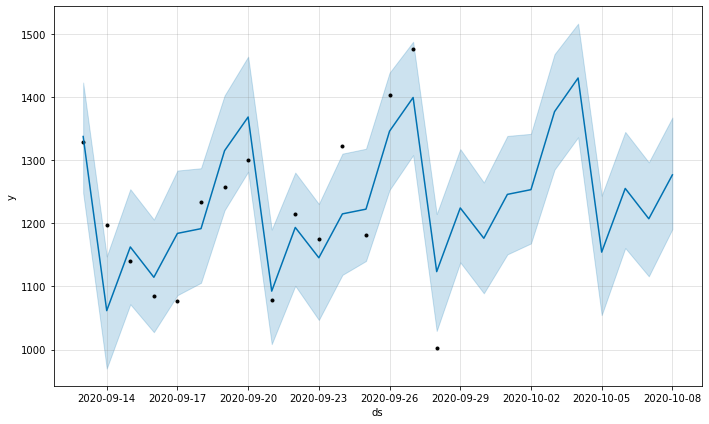

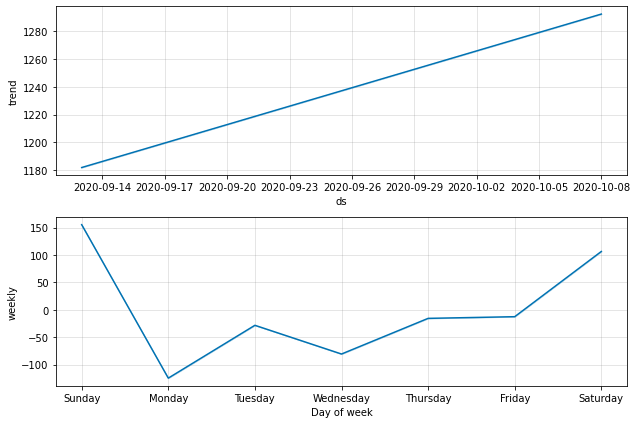

In [169]:
from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=0.05).fit(ts4)
future = m.make_future_dataframe(periods=10, freq='D')
fcst = m.predict(future)
y_hat = m.plot(fcst)

fig = m.plot_components(fcst) #breakdown of weekday seasonality and the time trend

Lets look at intraday seasonality and break down the posting frequency by hours:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


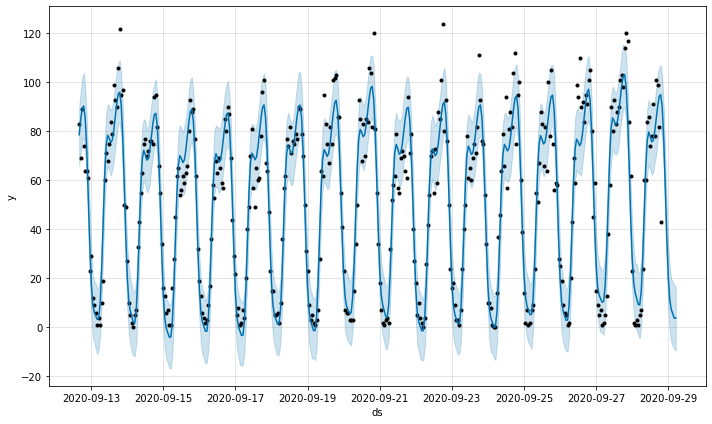

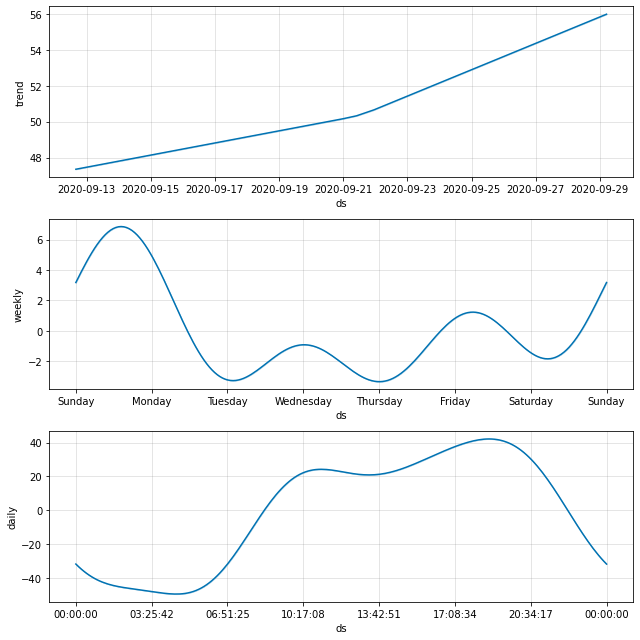

In [170]:
ts5 = ts3.resample('60T').sum()
ts5['ds'] = ts5.index
ts5.rename(columns={'count':'y'}, inplace = True)
#ts5.drop(min(ts4.index), inplace = True) # dropping the 12th since it is not complete for daily aggregation

m = Prophet(changepoint_prior_scale=0.1).fit(ts5)
future = m.make_future_dataframe(periods=10, freq='H')
fcst = m.predict(future)
y_hat = m.plot(fcst)

fig = m.plot_components(fcst) #breakdown by time trend, weekday seasonality and intraday seasonality

##### Lets look at the tags

In [273]:
tags_all = pd.Series([tag for row in df.tags for tag in row])
len(tags_all) #153160

toptags = tags_all.value_counts().rename_axis('unique_values').reset_index(name='counts')[:10] #48445 unique hashtags
# most used was helsinki with 3027
#print(toptags)
for tag in toptags["unique_values"]:
    df[tag] = df["tags"].apply(lambda x: 1 if tag in x else 0)

In [270]:
ts = df.set_index("timestamp")
ts = ts.resample('60T').sum()
ts['ds'] = ts.index

ts.rename(columns={toptags["unique_values"][0]:'y'}, inplace = True) #choose the tag to forecast 0 = top tag, 1 = 2nd etc

ts_tags = ts.rename(columns={'count':'y'})
ts_tags.drop(min(ts_tags.index), inplace = True) # dropping the 12th since it is not complete for daily aggregation


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


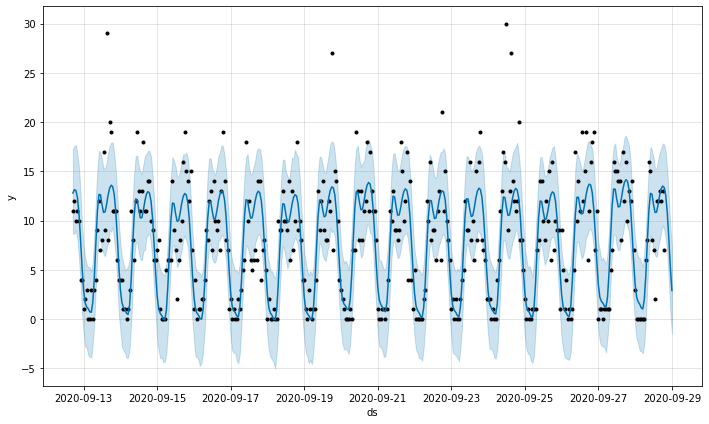

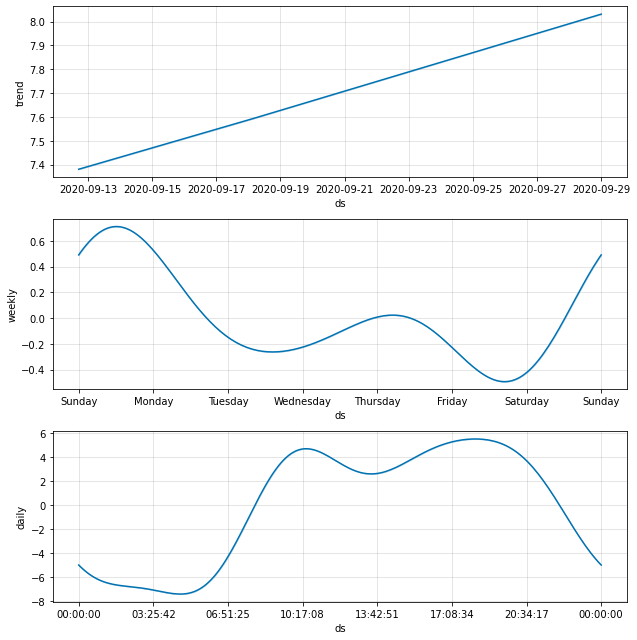

In [271]:
m = Prophet().fit(ts_tags)
future = m.make_future_dataframe(periods=5, freq='H') #choose the frequency to plot
fcst = m.predict(future)
y_hat = m.plot(fcst)

fig = m.plot_components(fcst) #time trend and weekday seasonality